In [1]:
# utilization
import os
from tqdm import tqdm
from glob import glob
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data manipulation and visualization tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# cross-validaion and evaluation tools
from sklearn.model_selection import train_test_split

# model development and data preparation
import torch
import torchvision
from create_dataset import *

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.io import read_image
from torchvision import transforms


# GradCAM implementations and some utility tools
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

torch.backends.cudnn.benchmark = True

/Users/michaelyuan/opt/anaconda3/envs/grad_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare the dataset

In [2]:
# image data path
DATAPATH = r'american_bankruptcy.csv'

logging.basicConfig(level=logging.INFO)
df_raw = load_data(DATAPATH)

# dataset = create_dataset(df_raw)

INFO:root:Preprocessing data...
100%|██████████| 8971/8971 [01:31<00:00, 98.50it/s] 


In [3]:
# ratios_df = ratios_dataframe(df_raw)
# # ratios_df['test'] = df_raw["X9"] / df_raw["X16"]
# # print(ratios_df['test'].describe())
# for colunm in ratios_df.columns:
#     if ratios_df[colunm].isnull().any():
#         print(ratios_df[colunm].isnull())
# # print(ratios_df['X9/X16'].head())

In [4]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        sample = sample.permute(1, 2, 0).reshape(64, 64)
        image = plt.cm.gray(sample)

        axs[0, i].imshow(sample, cmap='gray')
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

In [6]:
# train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
X, y = df_raw.drop(columns=['status_label']), df_raw['status_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_df, test_df = pd.concat([X_train, y_train], axis=1), pd.concat([X_test, y_test], axis=1)
train_data, test_data = create_dataset(train_df, oversampling=True), create_dataset(test_df, oversampling=False)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

/Users/michaelyuan/opt/anaconda3/envs/grad_env/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
/Users/michaelyu

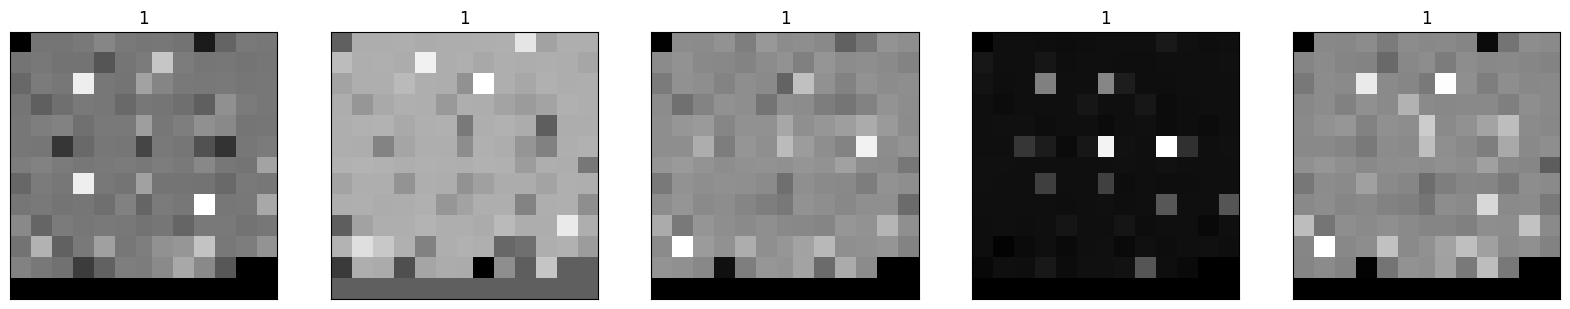

In [24]:
show(test_loader.dataset)
# print(df_raw.head())
# print(dataset[:3])

# Grad-CAM

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(SimpleCNN, self).__init__()

        # Convolutional layer 1
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Fully connected layer 1
        self.fc1 = nn.Linear(64 * 16 * 16, 64)  # input image size is 64x64
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Helper function to run grad-cam

In [29]:
from typing import List, Callable, Optional

def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable = GradCAM):
    with method(model=model,
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)
        # print(repeated_tensor.shape)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            # visualization = cv2.resize(visualization,
            #                            (visualization.shape[1]*4, visualization.shape[0]*4))
            results.append(visualization)
        return results, batch_results

### run and visualize

In [63]:
def get_classed_images(dataset, class_label = 0, N = 5):
    random_indices = np.random.randint(0, len(dataset), N)

    samples = []
    for idx in random_indices:
        i = idx
        while dataset[i][1] != class_label:
            i = i + 1 if i+1 < len(dataset) else 0
        samples.append(dataset[i][0])
    
    image_tensors = torch.cat(samples, dim=0)

    return image_tensors

image_tensors_0 = get_classed_images(test_data, class_label = 0)
image_tensors_1 = get_classed_images(test_data, class_label = 1)

In [64]:
def run_classed_gradcam(image_tensors):
    images, class_heatmaps, grayscale_cams = [], [[], []], [[], []]
    for image_tensor in image_tensors:
        image = transforms.ToPILImage()(image_tensor).convert("RGB")
        images.append(image)
        heatmaps, grayscale_cam = run_grad_cam_on_image(model=model,
                            target_layer=target_layer,
                            targets_for_gradcam = targets,
                            reshape_transform=None,
                            input_tensor=image_tensor.unsqueeze(0),
                            input_image=image)
        
        class_heatmaps[0].append(heatmaps[0])
        class_heatmaps[1].append(heatmaps[1])
        grayscale_cams[0].append(grayscale_cam[0])
        grayscale_cams[1].append(grayscale_cam[1])
    return images, class_heatmaps, grayscale_cams

In [65]:
def display_gradcam(images, grayscaled_cam, heatmaps_on_inputs, labels, N=5):
    viz_img_list = [images, grayscaled_cam, heatmaps_on_inputs]
    subfig_titles = ["Input Images", "Heatmap for Class 0", "Heatmaps for Class 1"]
            
    fig = plt.figure(figsize=(20, 10))
    subfigs = fig.subfigures(nrows=3, ncols=1)

    fig.suptitle(f'GradCAM for layer: {2}', fontsize=18, y=1.05)
    for subfig_idx, subfig in enumerate(subfigs):
        subfig.suptitle(subfig_titles[subfig_idx], y=1)
                
        viz_list = viz_img_list[subfig_idx]
                
        axs = subfig.subplots(nrows=1, ncols=N)
        for idx in range(N):
            axs[idx].imshow(viz_list[idx], cmap='gray')              
            axs[idx].set_title("Class {}".format(int(labels[idx])))   
            axs[idx].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
                
    plt.show()


### Normal Model

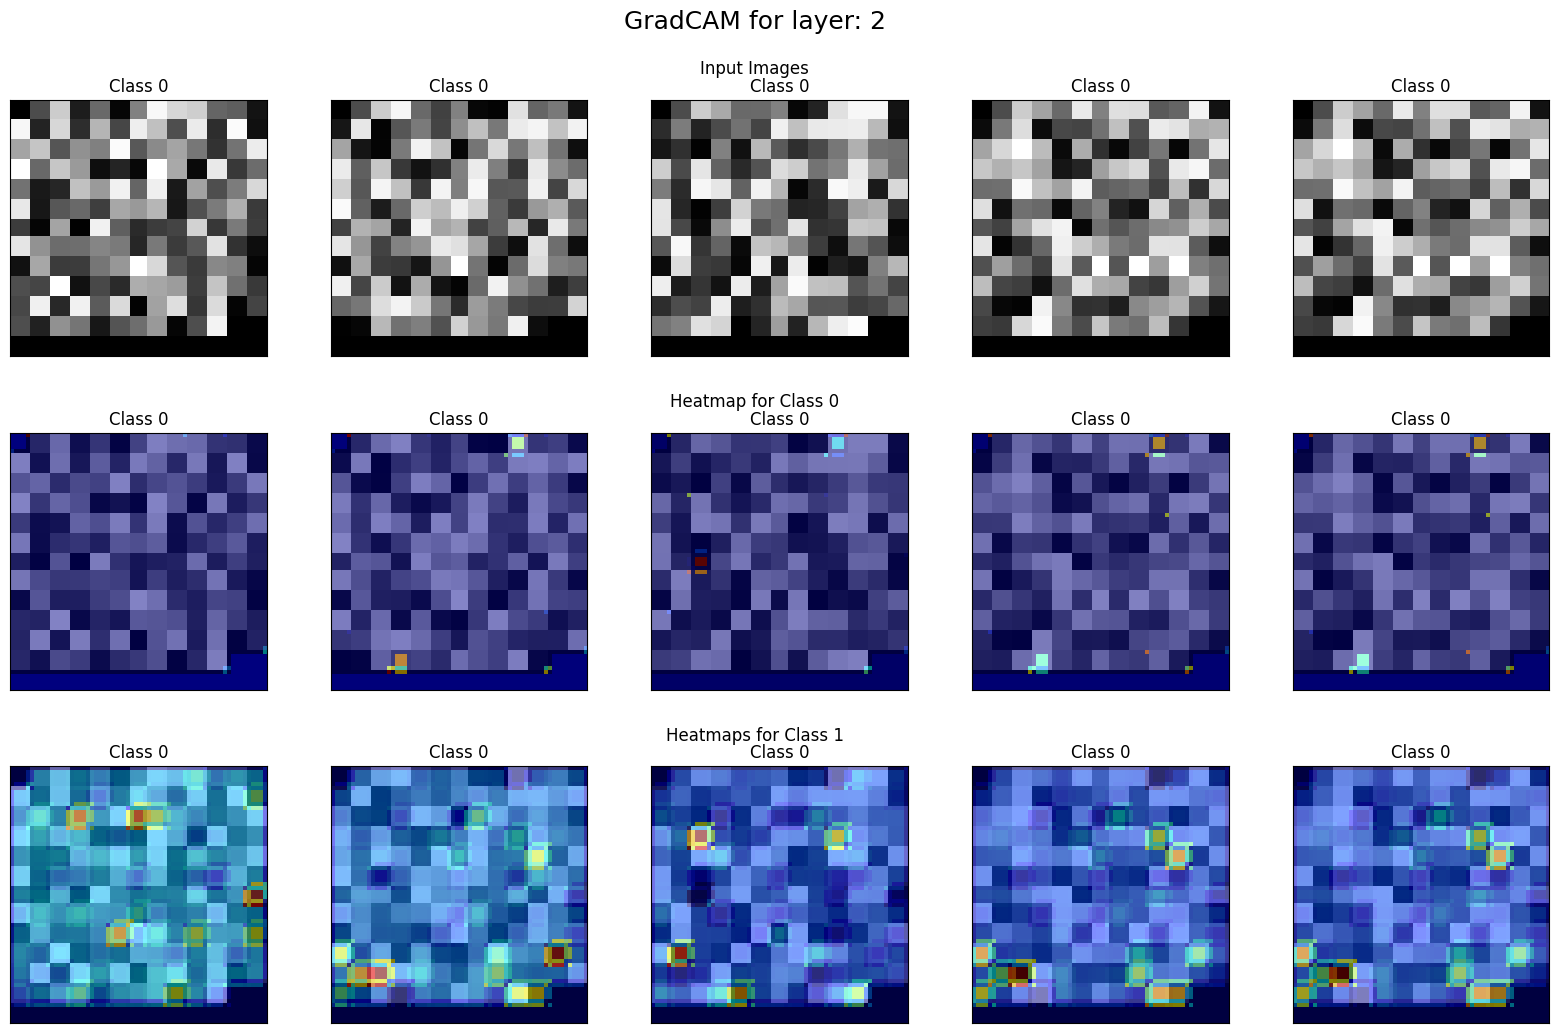

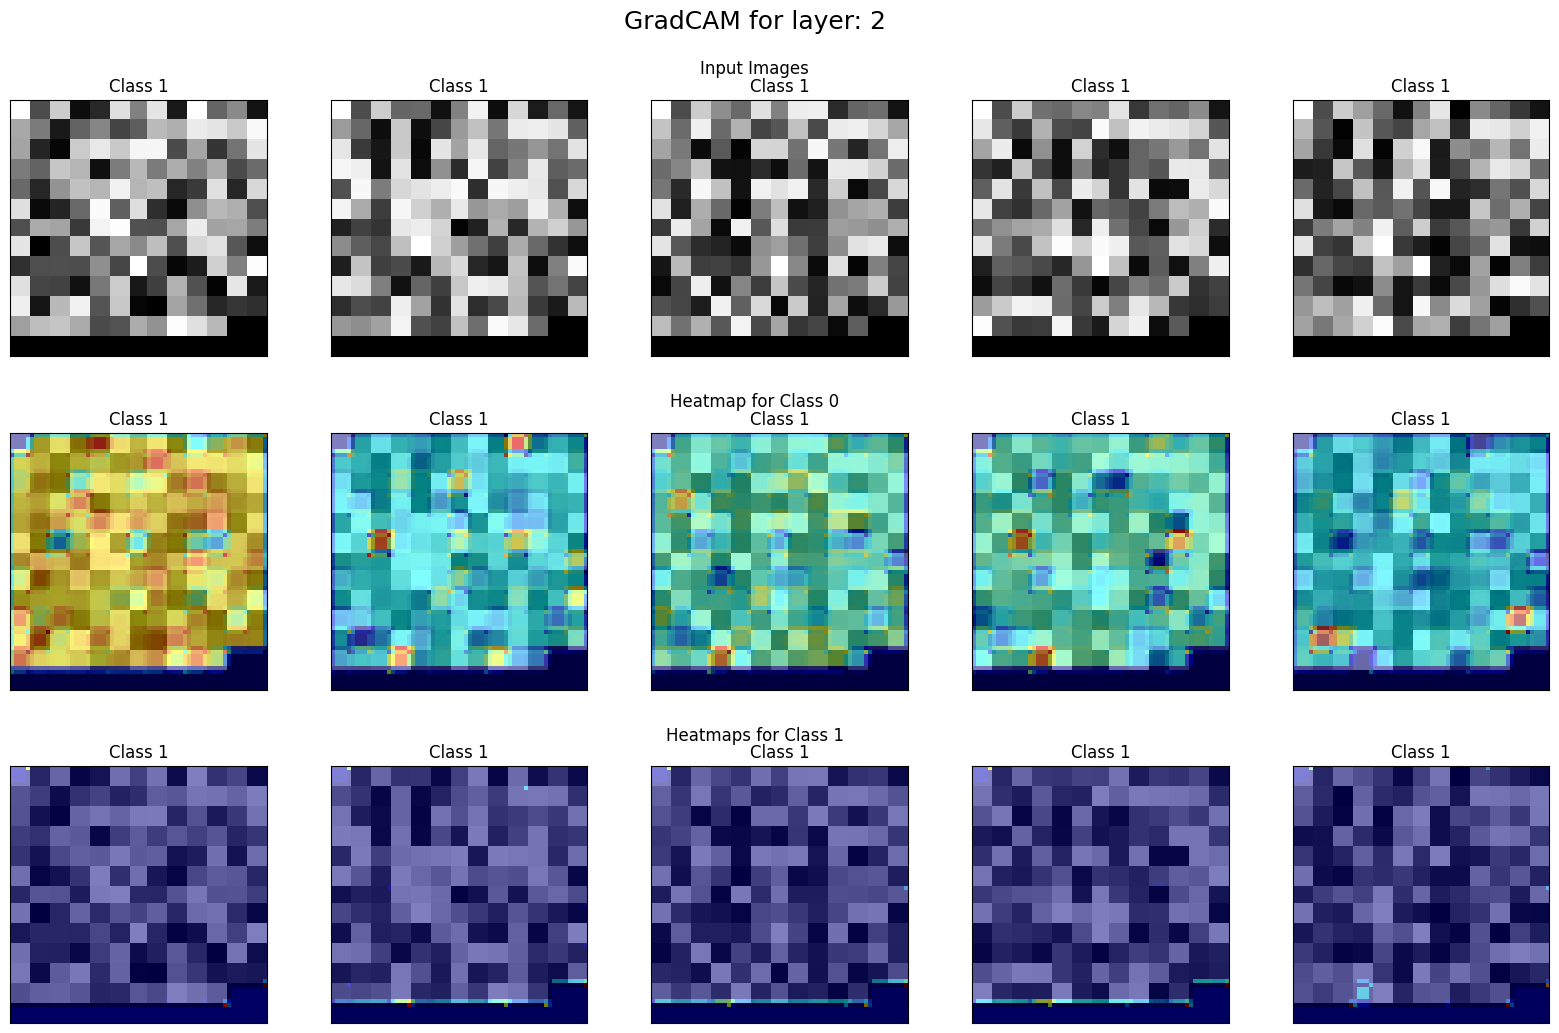

In [66]:
targets = [ClassifierOutputSoftmaxTarget(i) for i in range(2)]

model = torch.load('models/model2.pt')
model.eval()
target_layer = model.conv1

images_0, class_0_heatmaps, grayscale_cams_0 = run_classed_gradcam(image_tensors_0)
images_1, class_1_heatmaps, grayscale_cams_1 = run_classed_gradcam(image_tensors_1)

display_gradcam(images_0, class_0_heatmaps[0], class_0_heatmaps[1], labels = np.zeros(len(images_0)))
display_gradcam(images_1, class_1_heatmaps[0], class_1_heatmaps[1], labels = np.ones(len(images_1)))

### Model with Controlled top 10 Ratios

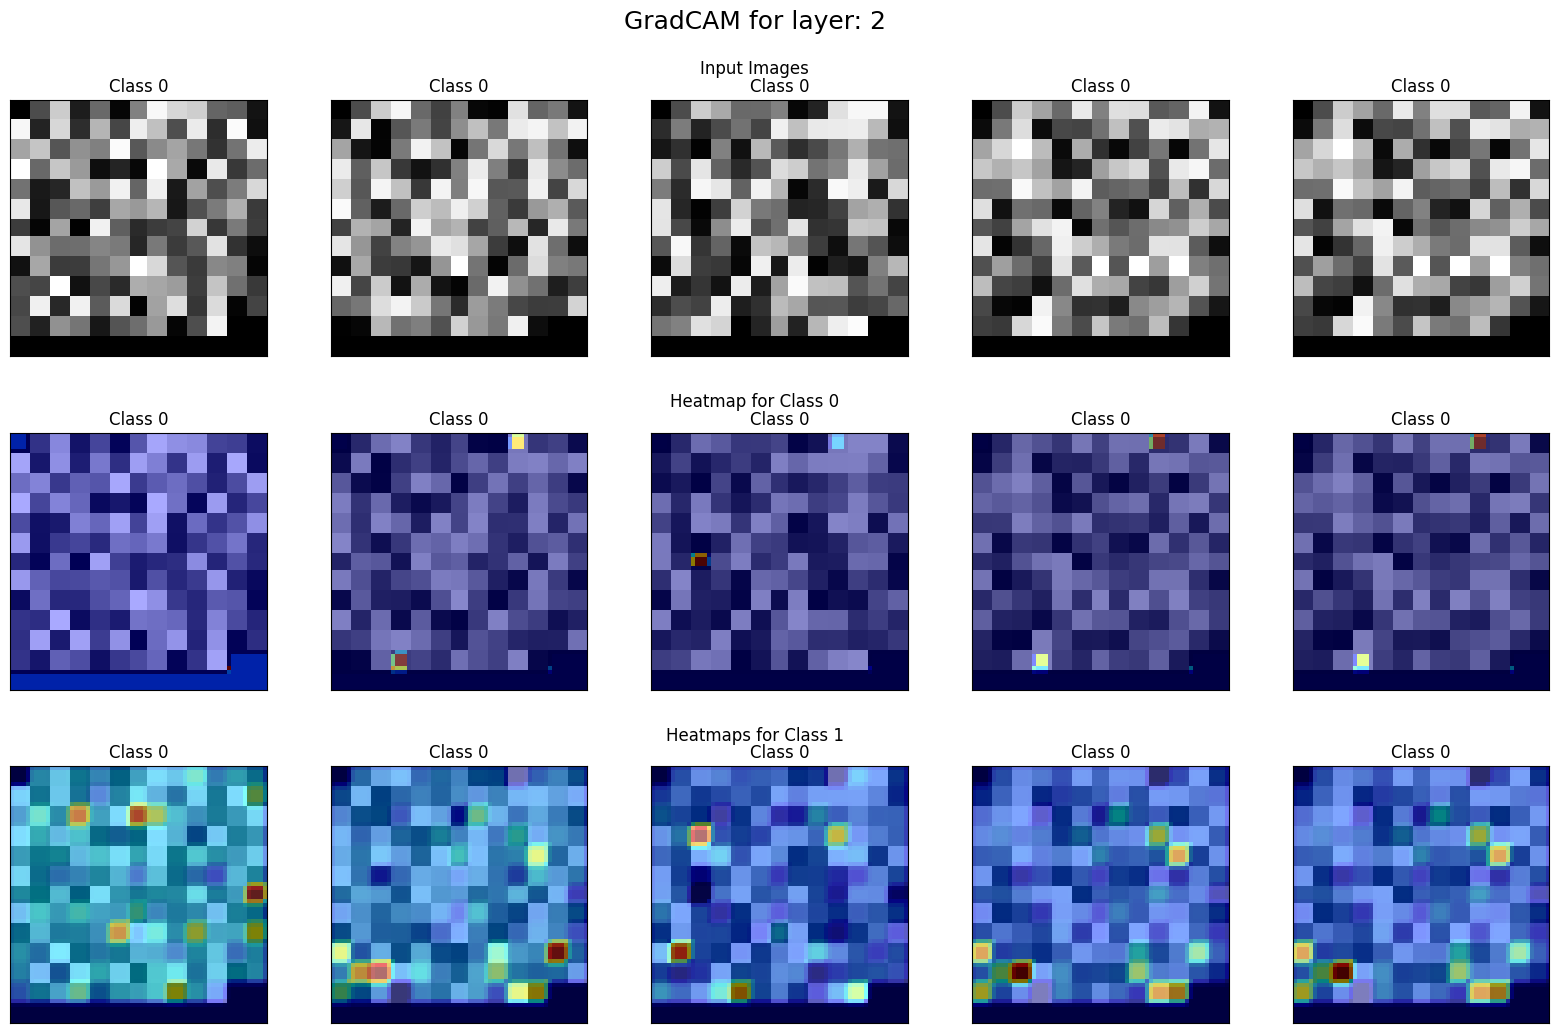

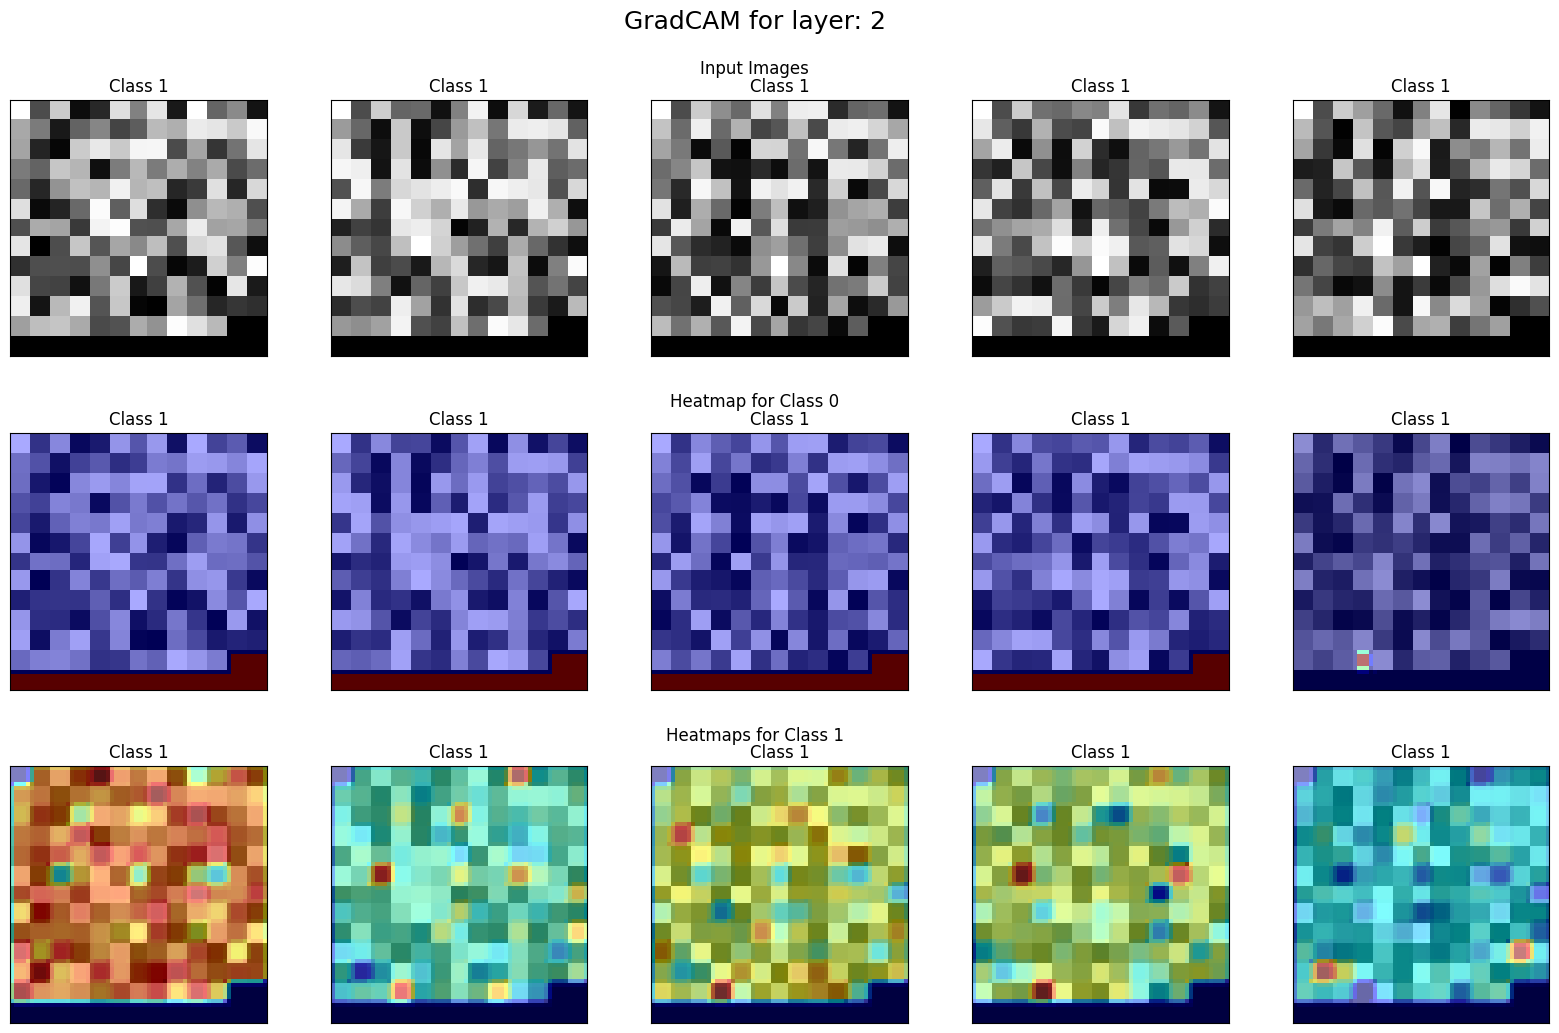

In [67]:
model = torch.load('models/model_GradCAM1_controlled.pt')
# model = torch.load('models/model_random.pt')
model.eval()
target_layer = model.conv1

images_0, class_0_heatmaps, grayscale_cams_0 = run_classed_gradcam(image_tensors_0)
images_1, class_1_heatmaps, grayscale_cams_1 = run_classed_gradcam(image_tensors_1)

display_gradcam(images_0, class_0_heatmaps[0], class_0_heatmaps[1], labels = np.zeros(len(images_0)))
display_gradcam(images_1, class_1_heatmaps[0], class_1_heatmaps[1], labels = np.ones(len(images_1)))

### Model with Random Controlled

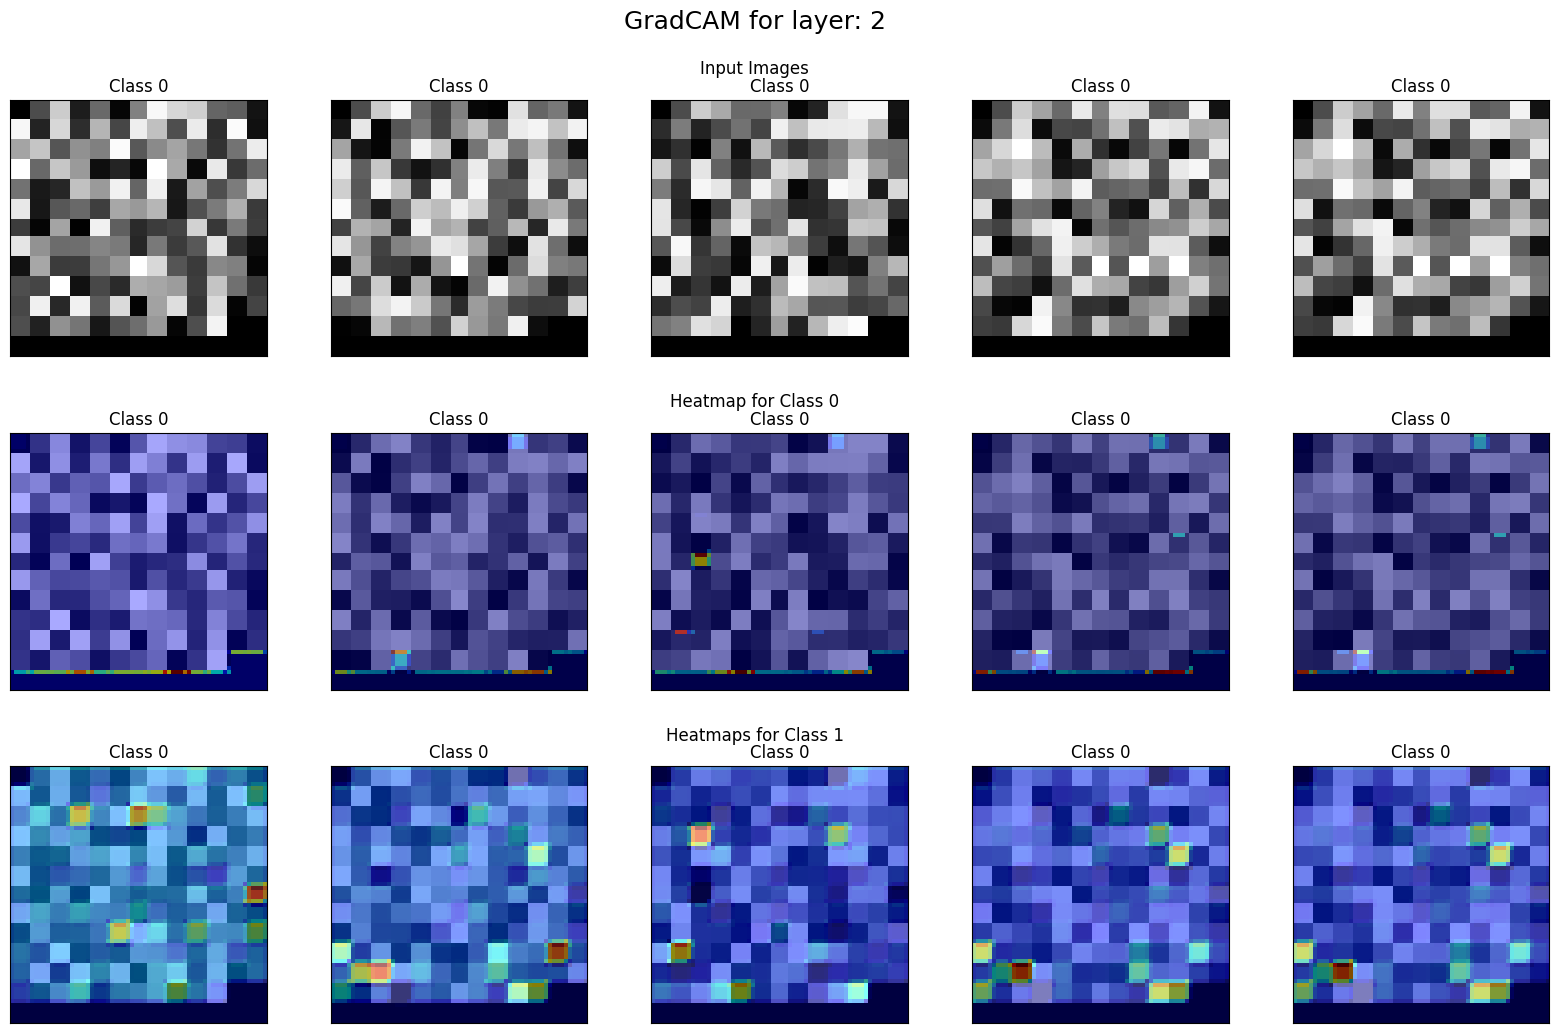

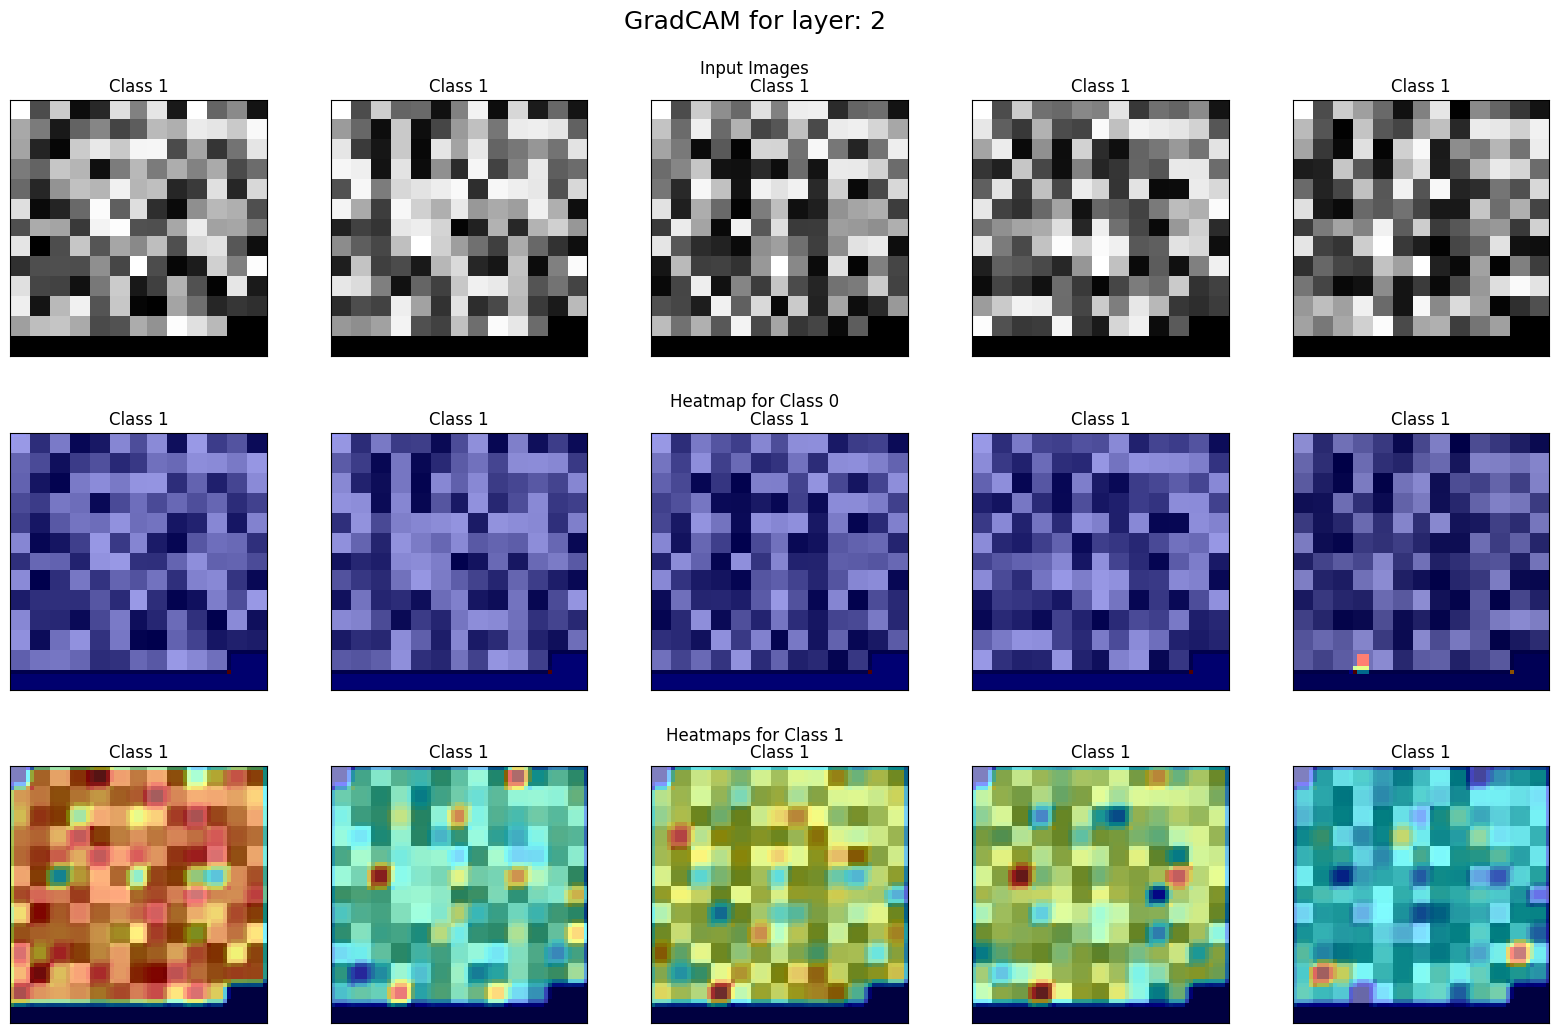

In [68]:
# model = torch.load('models/model_controlled.pt')
model = torch.load('models/model_random.pt')
model.eval()
target_layer = model.conv1

images_0, class_0_heatmaps, grayscale_cams_0 = run_classed_gradcam(image_tensors_0)
images_1, class_1_heatmaps, grayscale_cams_1 = run_classed_gradcam(image_tensors_1)

display_gradcam(images_0, class_0_heatmaps[0], class_0_heatmaps[1], labels = np.zeros(len(images_0)))
display_gradcam(images_1, class_1_heatmaps[0], class_1_heatmaps[1], labels = np.ones(len(images_1)))

### Get Top 10 significant factor

In [69]:
def resize_image(image_array, new_size=(64, 64)):
    # Enlarge the image array
    image_pil = Image.fromarray(image_array)
    enlarged_image_pil = image_pil.resize(new_size, Image.NEAREST)
    enlarged_image_array = np.array(enlarged_image_pil)
    
    return enlarged_image_array

In [70]:
def array_to_label(array):
    label = np.full(169, " ", dtype="S8")
    p = 0
    for i in range(18):
        for j in range(i+1, 18):
            if array[j] != 0:
                # print(label[p].dtype)
                label[p] = "X{}/X{}".format(i+1, j+1)
                p+=1
    label = label.reshape(13, 13)
    return label

labels = array_to_label(np.ones(169))
print(labels[5][9])

b'X5/X18'


In [71]:
def get_top_10_index(array):
    array = resize_image(array, new_size=(13, 13)) # Get absolute value of contribution
    top10_idx = reversed(np.argsort(array, axis=None)[-10:]) # Decending order
    # print(top10_idx)
    top10_idx = [(idx // 13, idx % 13) for idx in top10_idx] # get row and column index
    return top10_idx

# for grayscale_cam in grayscale_cams_0[1]:
#     print(grayscale_cam.shape)
#     top_10_idx = get_top_10_index(grayscale_cam)
#     print(top_10_idx)


In [80]:
def top_10_ratios(dataset, class_label = 0, N = 100):
    ratio_count = np.zeros(169).reshape(13, 13)
    for i in range(2):
        class_label = i
        image_tensors = get_classed_images(dataset, class_label = class_label, N = N)
        _, _, grayscale_cams = run_classed_gradcam(image_tensors)

        # grayscale_cams contains results for both classes as target (0 and 1)
        for labeled_cams in grayscale_cams:
            for grayscale_cam in labeled_cams:
                top_10_idx = get_top_10_index(grayscale_cam)
                # print(top_10_idx)
                for idx in top_10_idx:
                    if (idx[0] != 12) or (idx[0] == 11 and idx[1] < 10): # if not padding
                        ratio_count[idx[0]][idx[1]] += 1 

    top_10_ratios_idx = get_top_10_index(ratio_count)
    
    return top_10_ratios_idx

model = torch.load('models/model2.pt')
model.eval()
target_layer = model.conv1

# Search for top 10 ratios in class 0
top_10_ratios_idx = top_10_ratios(test_data, N = 1000)
np.save("index/GradCAM_Top10.npy", top_10_ratios_idx)


# Search for top 10 ratios in class 1
# top_10_ratios_idx_1 = top_10_ratios(test_data, class_label=1, N = 1000)
# np.save("top_10_idx_class1.npy", top_10_ratios_idx_1)
    

In [84]:
print("Top 10 Ratios:")
for idx in top_10_ratios_idx:
    print(labels[idx[0]][idx[1]], idx)

# print("---------------------------------")

# print("Top 10 Ratios in class 1:")
# for idx in top_10_ratios_idx_1:
#     print(labels[idx[0]][idx[1]], idx)

Top 10 Ratios:
b'X3/X4' (2, 7)
b'X14/X18' (11, 3)
b'X1/X11' (0, 9)
b'X1/X2' (0, 0)
b'X11/X18' (10, 1)
b'X13/X14' (10, 8)
b'X17/X18' (11, 9)
b'X5/X6' (4, 10)
b'X10/X11' (9, 0)
b'X14/X15' (11, 0)
